## Лабораторная работа по модулю "*Построение моделей*"

Необходимо решить задачу мультиклассовой классификации для датасета флагов различных стран 
(https://archive.ics.uci.edu/ml/datasets/Flags)

1. Загрузить данные из папки Data Folder
2. Провести описательный анализ предложенных данных
3. Предложить стратегию по работе с категориальными переменными 
4. Провести углубленный анализ данных (корреляции переменных, визуализация взаимосвязей)
5. Следует ли увеличивать/уменьшать размерность признакового множества (какой подход выдает лучшие результаты)
6. Следует ли балансировать классы путем oversampling/undersampling? (улучшает ли подход результаты)
7. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=3)
8. Решить задачу мультиклассовой классификации и предсказать религию страны (religion) по деталям ее флага 
9. Рассчитать Feature Importances для переменных модели
10. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
11. Построить Confusion Matrix для ваших результатов
12. Загрузить ipython notebook с результатами работы на github репозиторий

In [329]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, f1_score, precision_score
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from jupyterthemes import jtplot
from pathlib import Path
from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
%matplotlib inline
jtplot.style()

**Подготовка данных**

In [128]:
def parse(filename):
    names = list()
    for line in Path(filename).read_text().split('\n'):
        tpl = re.search(r'[0-9]{1,3}\. [a-z]*?[\t\x20]', line)
        if tpl:
            names.append(tpl.group().strip().split()[1])
    return names

In [129]:
names = parse('flag.names')
target_religions = ['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Others']

data = pd.read_csv('flag.data', header=None, names=names)
data.head(4)

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red


Относительно признакового множества: увеличивать точно не стоит, потому что после приведения категорийных признаков в удобочитаемый машинный формат (с помощью *pd.get_dummies(...)* или *OneHotEncoder*), количество признаков синтетичски разрастается до ~200, в результате чего те же feature importances не несут никакой информативности. В качестве примера ниже рассмотрим случай, когда остался единственный категорийный признак *name*, а также удалены некоторые признаки начального датасета (цавета, наличие горизонтальных и вертикальных полос и т.д.) 

In [135]:
redundunt_features = ['zone', 'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'triangle', 'icon', 'animate', 'topleft', 'botright']

X = data.drop(columns=redundunt_features)
X.drop(columns=['religion', 'name'], inplace=True)
X = pd.concat([pd.get_dummies(data['name']), X], axis=1)
y = data['religion']

rf_cl = RandomForestClassifier(n_estimators=10, max_depth=7, min_samples_leaf=20, n_jobs=-1)
kf = KFold(n_splits=3)

for split, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    rf_cl.fit(X_train, y_train)
    y_predict = rf_cl.predict(X_test)
    
    # выводим первые 4 feature importances
    print('-'*20 + f'\nfeature importances for split #{split}\n' + '-'*20)
    for feature, imp in sorted(zip(X.columns, rf_cl.feature_importances_), key=lambda im: im[1], reverse=True)[:4]:
        print(f'{feature}: {imp:.4f}')

--------------------
feature importances for split #0
--------------------
Afghanistan: 0.0000
Albania: 0.0000
Algeria: 0.0000
American-Samoa: 0.0000
--------------------
feature importances for split #1
--------------------
landmass: 0.4000
area: 0.2000
population: 0.2000
language: 0.2000
--------------------
feature importances for split #2
--------------------
population: 0.5000
language: 0.5000
Afghanistan: 0.0000
Albania: 0.0000


Поэтому будем исследовать два признаковых множества:
1. удалены признаки *name*, цвета, т.к. признак *colours* говорит о факте наличия определенного количества цветов на флаге, и *topleft* + *botright*
2. присутствуют все признаки, за исключением *name* и географического квадранта (*zone*), потому что для второго уже присутствует признак принадлежности к материку

Категорийные признаки закодируем с использованием *pd.get_dummies(...)*.

In [349]:
redundunt_features_upd = ['name', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'topleft', 'botright']

X_reduced_1 = data.drop(columns=redundunt_features_upd)
X_reduced_1.drop(columns=['religion'], inplace=True)
num_cols = list(X_reduced_1.select_dtypes(include=['int64', 'float64']).columns)
obj_cols = list(X_reduced_1.select_dtypes(include=['object']).columns)
X_reduced_1 = pd.concat([pd.get_dummies(X_reduced_1[obj_cols]), X_reduced_1[num_cols]], axis=1)

X_reduced_2 = data.drop(columns=['name', 'zone', 'religion'])
num_cols = list(X_reduced_2.select_dtypes(include=['int64', 'float64']).columns)
obj_cols = list(X_reduced_2.select_dtypes(include=['object']).columns)
X_reduced_2 = pd.concat([pd.get_dummies(X_reduced_2[obj_cols]), X_reduced_2[num_cols]], axis=1)

y = data['religion']

**Построение модели**

Относительно over/undersampling. Учитывая, что у нас сэмплов в принципе не так много, логичнее воспользоваться oversampling'ом, т.е. добавлением сэмплов миноритарного(-ых) класса(-ов). В самом простом случае можно попробовать продублировать имеющиеся семплы случайным образом. В нашем случае это семплы для классов 4 и 7, т.к. их всего по 4 штуки. Можно попробовать расширить количество сэмплов для каждого из них хотя бы до ближайшего класса, т.е. до 8 (3 класс). 

Но сначала нужно поделить данные на обучаемую и тестовую выборки, а уже потом смотреть сколько сэмплов осталось в обучаемой выборке (тестовую не трогаем, т.к. это может сказаться на результатах предсказаний), и решать, стоит ли вообще пользоваться оверсемплингом, или оставить все как есть, потому что наличие 1-2 сэмплов миноритарных классов вряд ли сильно повлияет на конечный результат.

Вообще можно воспользоваться, например, техникой SMOTE (Synthetic Minority Oversampling Technique).

In [122]:
y.value_counts()

1    60
0    40
2    36
5    27
6    15
3     8
7     4
4     4
Name: religion, dtype: int64

In [276]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X_reduced_1, y, test_size=0.2)

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)))

[[ 0  1  2  3  4  5  6  7]
 [33 49 25  6  3 22 14  3]]


Видим, что количество сэмплов для двух миноритарных классов уменьшилось, поэтому проведем оверсемплинг, используя библиотеку imblearn

**!NB** SMOTE ругается, когда количество соседей больше количества семплов для миноритарных классов, поэтому выбран параметр k_neighbors=2

In [277]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_train_1, y_train, test_size=0.2)

sm = SMOTE(k_neighbors=2)
X_train_upd, y_train_upd = sm.fit_resample(X_train_sm, y_train_sm)

unique, counts = np.unique(y_train_upd, return_counts=True)
print(np.asarray((unique, counts)))

[[ 0  1  2  3  4  5  6  7]
 [38 38 38 38 38 38 38 38]]


**Сравнение оверфиченных данных и исходных**

In [301]:
rf_cl_1 = RandomForestClassifier(n_estimators=15, max_depth=7, n_jobs=-1)
rf_cl_1.fit(X_train_upd, y_train_upd)

rf_cl_2 = RandomForestClassifier(n_estimators=15, max_depth=7, n_jobs=-1)
rf_cl_2.fit(X_train_1, y_train)

print('Oversampled results:')
print(f'Accuracy: {rf_cl_1.score(X_test_sm, y_test_sm)}')
print(f'Recall score: {recall_score(y_test_sm, rf_cl_1.predict(X_test_sm), average="macro")}')

print('\nTest results:')
print(f'Accuracy: {rf_cl_2.score(X_test_1, y_test)}')
print(f'Recall score: {recall_score(y_test, rf_cl_2.predict(X_test_1), average="macro")}')

Oversampled results:
Accuracy: 0.6129032258064516
Recall score: 0.4920454545454545

Test results:
Accuracy: 0.7692307692307693
Recall score: 0.5616883116883117


Видим, что результаты точности и recall для тестовой выборки несколько лучше, чем для oversampled (на самом деле все зависит от запуска и других параметров, задаваемых для RandomForest). Поэтому далее продолжим анализ на исходных данных.

**Кросс-валидация и feature importances**

Осуществим кросс-валидацию для обоих признаковых подмножеств и выведем важность признаков

In [302]:
def rf_cv(X, y):
    rf = RandomForestClassifier(n_estimators=10, max_depth=7, min_samples_leaf=20, n_jobs=-1)
    kf = KFold(n_splits=3)
    
    acc, rec = list(), list()
    for split, (train_i, test_i) in enumerate(kf.split(X)):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        y_predict = rf.predict(X_test)
        
        # выводим первые 4 feature importances
        print('-'*20 + f'\nfeature importances for split #{split}\n' + '-'*20)
        for feature, imp in sorted(zip(X.columns, rf.feature_importances_), key=lambda im: im[1], reverse=True)[:4]:
            print(f'{feature}: {imp:.4f}')

    return

***Первое признаковое подмножество***

In [304]:
rf_cv(X_reduced_1, y)

--------------------
feature importances for split #0
--------------------
population: 0.3223
language: 0.2776
area: 0.1657
zone: 0.1590
--------------------
feature importances for split #1
--------------------
landmass: 0.4099
language: 0.1808
zone: 0.1287
area: 0.1266
--------------------
feature importances for split #2
--------------------
landmass: 0.3064
population: 0.2523
area: 0.1885
language: 0.1191


Видим, что наиболее важными для определения религии являются признаки материковой принадлежности, населения, языка, и площади.

***Второе признаковое подмножество***

In [306]:
rf_cv(X_reduced_2, y)

--------------------
feature importances for split #0
--------------------
population: 0.2690
green: 0.1965
language: 0.1516
landmass: 0.1164
--------------------
feature importances for split #1
--------------------
landmass: 0.3710
area: 0.1000
population: 0.1000
stripes: 0.1000
--------------------
feature importances for split #2
--------------------
population: 0.1525
botright_red: 0.1332
landmass: 0.1224
botright_blue: 0.1000


Видим, что остаются такие признаки, как население, площадь и материковая принадлежность, но также встречаются и признаки цветов или их расположения на флаге.

**Оценка точности и построение confusion matrix**

Еще раз разделим выборки, зададим классификатор и посчитаем метрики

In [322]:
from tabulate import tabulate

def get_metrics(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    rf = RandomForestClassifier(n_estimators=10, max_depth=7, min_samples_leaf=20, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_predict = rf.predict(X_test)
    
    print_info = [
        ['Accuracy score:', rf.score(X_test, y_test)],
        ['F1-score:', f1_score(y_test, y_predict, average='macro')],
        ['Precision score:', precision_score(y_test, y_predict, average='macro')],
        ['Recall score:', recall_score(y_test, y_predict, average='macro')],
        ['Confusion matrix:', confusion_matrix(y_test, y_predict)]
    ]
    
    print(tabulate(print_info, tablefmt='plain'))
    
    mx = plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, normalize=None)
    mx.ax_.set_title('Confusion matrix')
    
    plt.show()

***Первое признаковое подмножество***

Accuracy score:    0.717948717948718
F1-score:          0.4999437696806117
Precision score:   0.4833333333333332
Recall score:      0.5343915343915344
Confusion matrix:  [[ 6  1  0  0  0  0]
                    [ 0 11  0  0  0  0]
                    [ 0  1  7  0  1  0]
                    [ 0  0  2  0  0  0]
                    [ 0  2  1  0  4  0]
                    [ 3  0  0  0  0  0]]


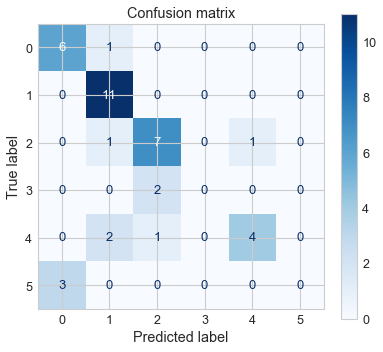

In [334]:
get_metrics(X_reduced_1, y)

***Второе признаковое подмножество***

Accuracy score:    0.5128205128205128
F1-score:          0.26327312534209085
Precision score:   0.23149350649350647
Recall score:      0.336734693877551
Confusion matrix:  [[5 4 1 0 0 0 0]
                    [0 9 0 0 0 0 0]
                    [0 1 6 0 0 0 0]
                    [0 2 1 0 0 0 0]
                    [0 1 2 0 0 0 0]
                    [3 2 0 0 0 0 0]
                    [0 1 1 0 0 0 0]]


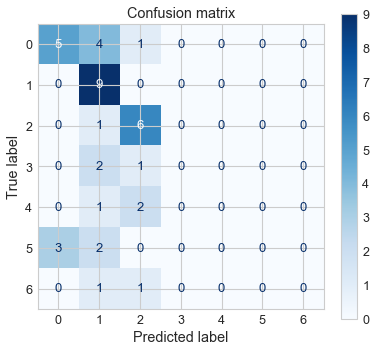

In [347]:
get_metrics(X_reduced_2, y)

Как видно из полученных данных, значения оценочных метрик получились низкими. Вероятно, на этом сказывается небольшое количество семплов, большое количество классов для такого количества семплов, ну и, наверное, сам факт того, что необходимо предсказывать религию по элементам флагов стран (: